# Komiya Diffusion Cell

Dr Daniel Duke
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
Department of Mechanical & Aerospace Engineering
Monash University, Australia

daniel.duke@monash.edu

We wish to solve Fick's second law:

$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}
$

where we know some arbitrarily scaled intensity $I(x,t) = a . C(x,t) + b$.

The data $I$ may be noisy so we wish to avoid computing the derivatives. Instead, we can fit an analytic solution.

In [1]:
import scipy.io
import numpy as np
import scipy.integrate, scipy.optimize
import matplotlib.pyplot as plt
%matplotlib notebook

In [115]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [124]:
# Read the data
mat = scipy.io.loadmat('test1ConcentrationLineProfiles.mat')
print("MAT file contents:",mat.keys())
item = 'line2'
I = mat[item][...]
print("I matrix:",I.shape)

spatialRes = 150. #px/mm
frameRate = 1.0 # fps

# Rescale the data to [0,1]
I = I / (np.nanmax(I) - np.nanmin(I))
I -= np.nanmin(I)

MAT file contents: dict_keys(['__header__', '__version__', '__globals__', 'line1', 'line2', 'line3'])
I matrix: (501, 458)


<IPython.core.display.Javascript object>


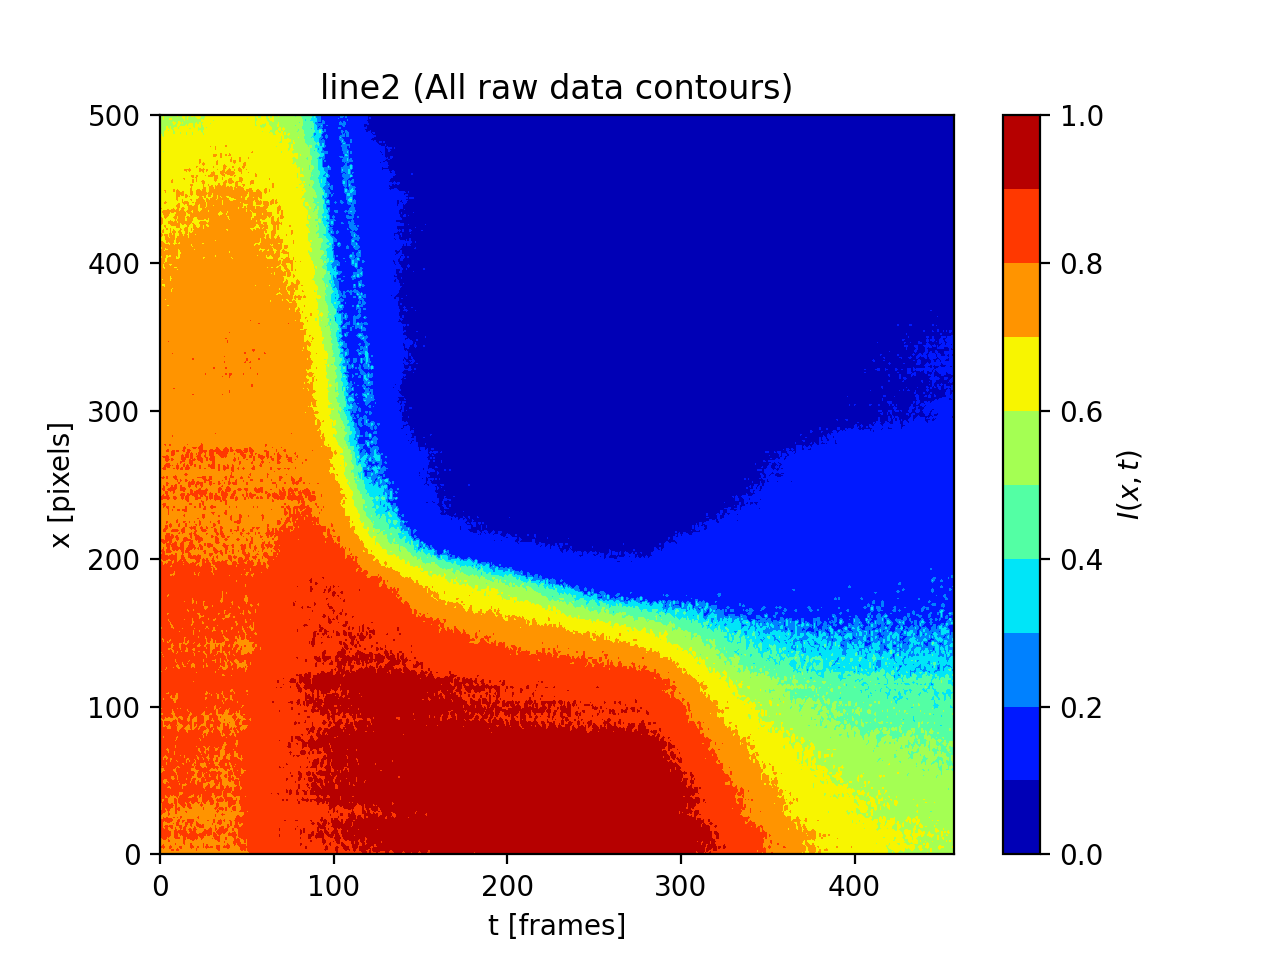

In [125]:
# Make independent axes variables as vectors
x = np.arange(I.shape[0])
t = np.arange(I.shape[1])

# Plot the raw data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("%s (All raw data contours)" % item)
ph = ax.contourf(t,x,I,levels=np.linspace(0,1,11),cmap=plt.cm.jet);
plt.colorbar(ph,label="$I(x,t)$")
plt.xlabel("t [frames]");
plt.ylabel("x [pixels]");

In [126]:
# Crop time so that we only keep data from the moment the diffusion begins, and no sooner. 
# This is the second 'knee' in the data above at about t=250-300 frames.

#I = I[0:350,260:] # line1
I = I[:,280:] # line2

<IPython.core.display.Javascript object>


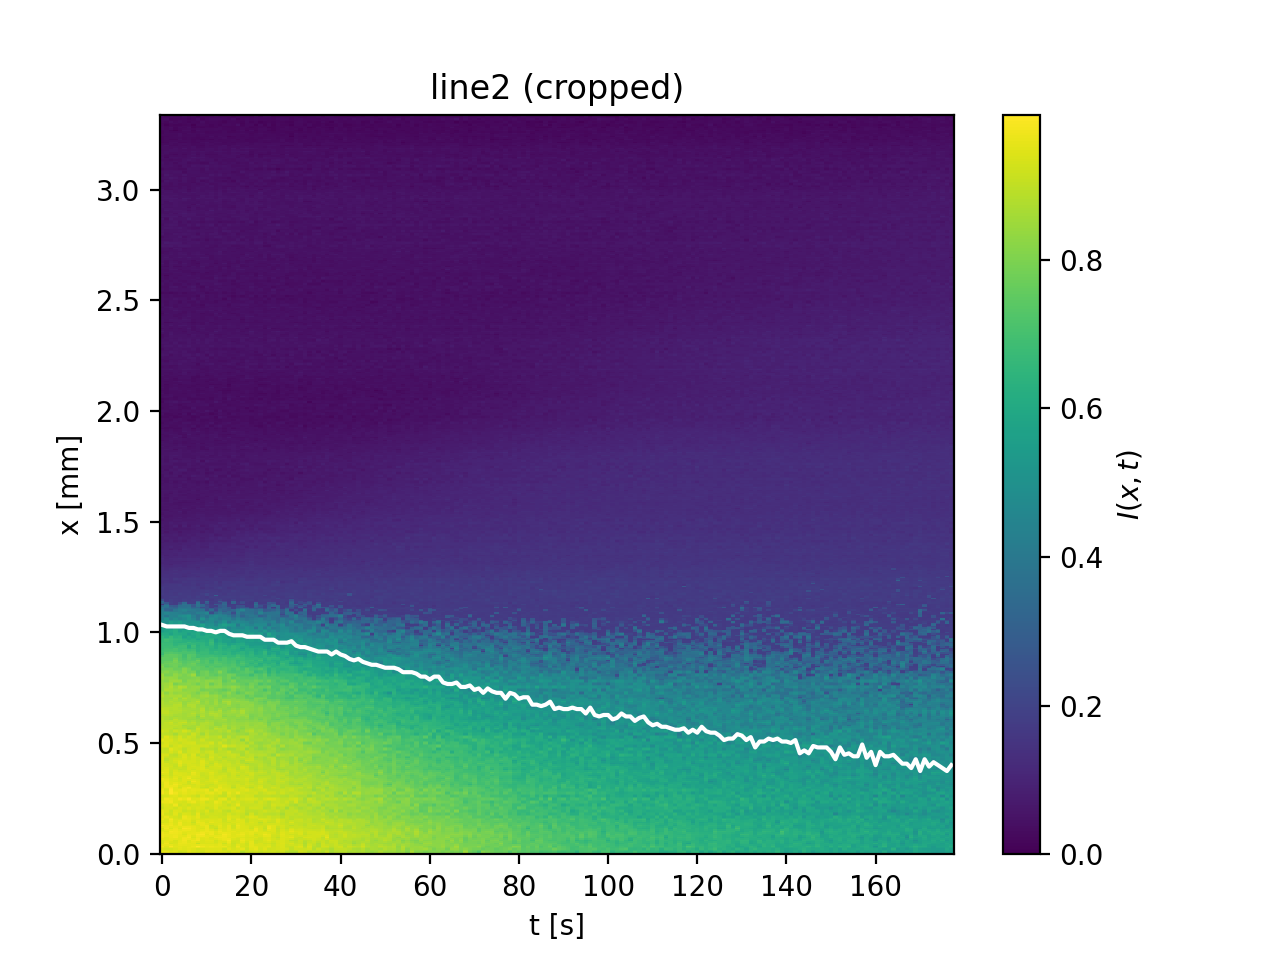

In [127]:
# Now plot the cropped data.

# Make independent axes variables as vectors
x = np.arange(I.shape[0])
t = np.arange(I.shape[1])

# Find the centre of the mixing layer vs time and shift the profiles so that it remains constant.
midpoint = np.zeros((I.shape[1],))
for i in range(I.shape[1]): # loop time
    # reversed direction of data in space so it's monotonically increasing.
    # also smooth the data to reduce noise in the centering.
    wr=64
    I_ = smooth(I[::-1,i],window_len=wr*2)[wr:-wr+1]
    x_ = x[::-1]
    midpoint[i] = np.round(np.interp(0.5,I_,x_),0) # nearest pixel

# Scale space and time physically
spatialRes = 150. #px/mm
frameRate = 1.0 # fps
t = t / frameRate # s
x = x / spatialRes # mm

# Plot the raw data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("%s (cropped)" % item)
tt,xx = np.meshgrid(t,x)
ph = ax.pcolormesh(tt,xx,I,shading='nearest');
ax.plot(t,midpoint/spatialRes,c='w',ls='-')
plt.colorbar(ph,label="$I(x,t)$")
plt.xlabel("t [s]");
plt.ylabel("x [mm]");

<IPython.core.display.Javascript object>


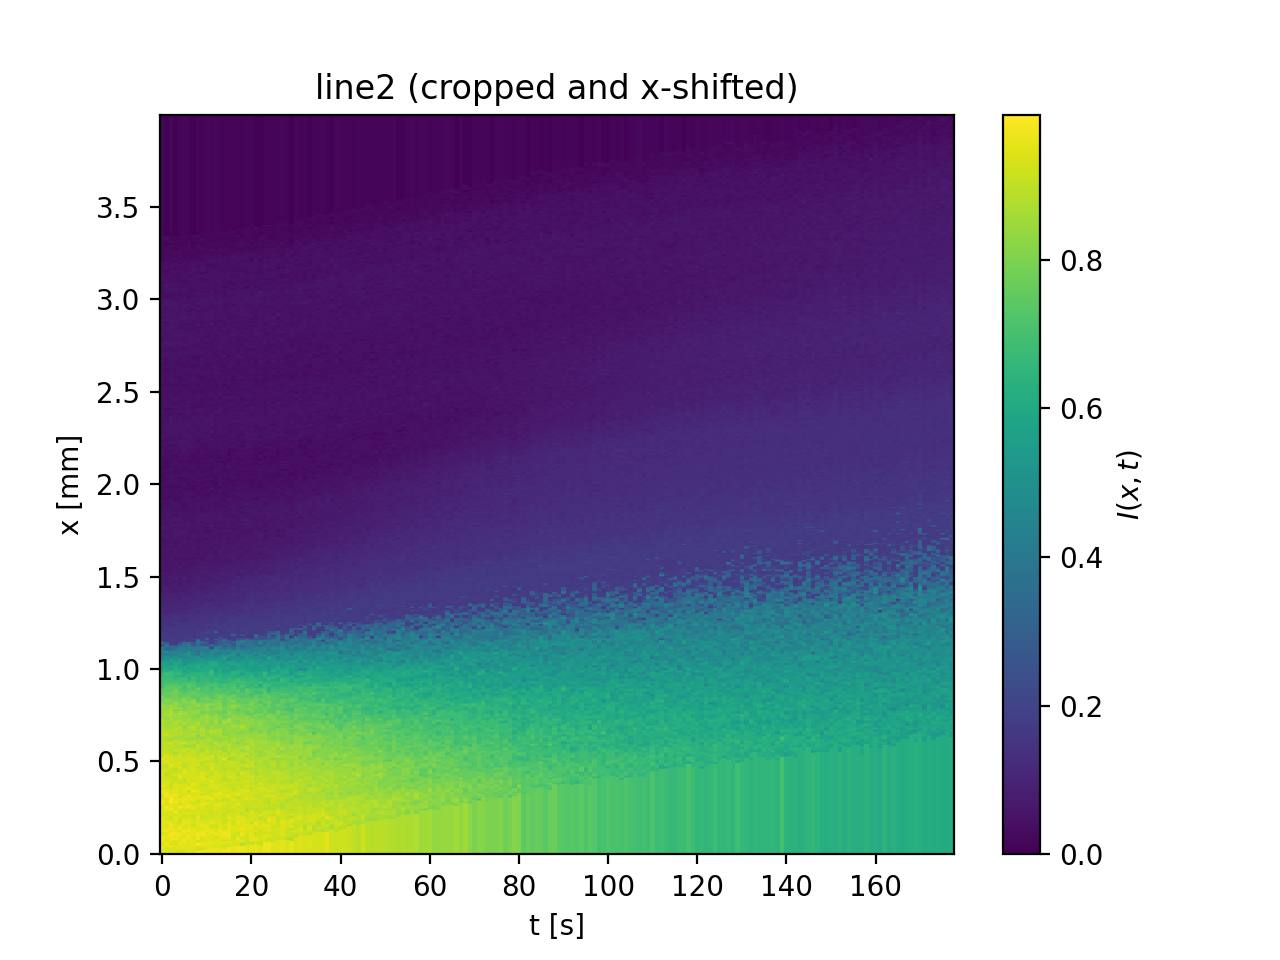

In [128]:
# Adjust x coordinate to center the profiles.

# Pad the array out in x
xpad = int(np.nanmax(midpoint)-np.nanmin(midpoint))
I2 = np.zeros((I.shape[0]+xpad,I.shape[1]))


# Place the profiles in place at each timestep, shifting the center appropriately.
for i in range(I.shape[1]): # loop time
    a = int(midpoint.max()-midpoint[i]) # offset in x, pixels
    I2[a:a+I.shape[0],i] = I[:,i] # put in data
    I2[:a,i] = I[:,i].max() # fill high value side with dummy values
    I2[a+I.shape[0]:,i] = I[:,i].min() # fill low value side with dummy values

# Make independent axes variables as vectors
x2 = np.arange(I2.shape[0]) / spatialRes
t2 = np.arange(I2.shape[1]) / frameRate

# Plot the data
fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("%s (cropped and x-shifted)" % item)
tt,xx = np.meshgrid(t2,x2)
ph = ax.pcolormesh(tt,xx,I2,shading='nearest');
plt.colorbar(ph,label="$I(x,t)$")
plt.xlabel("t [s]");
plt.ylabel("x [mm]");

<IPython.core.display.Javascript object>


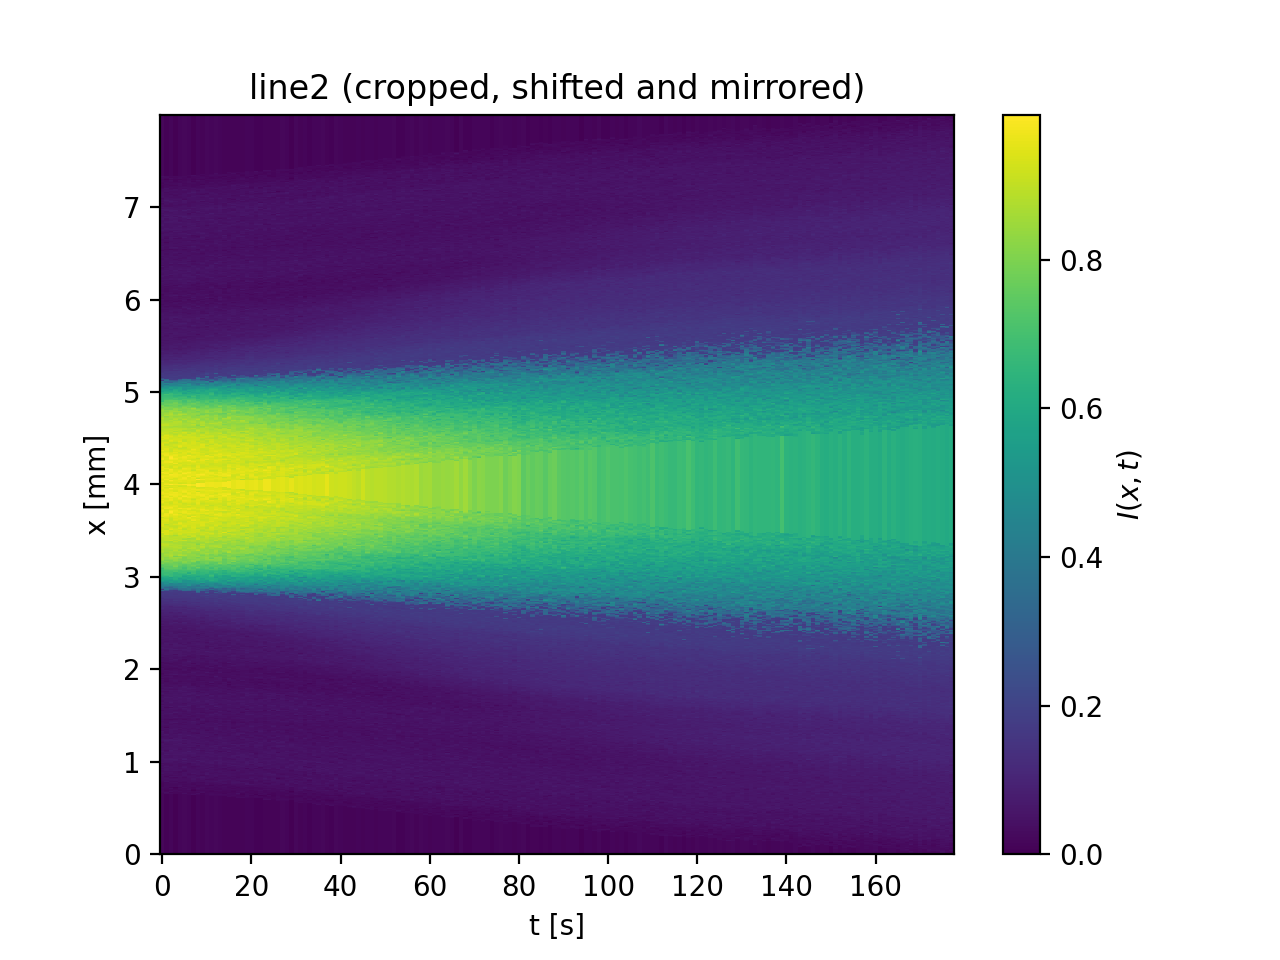

In [139]:
# Mirror the matrix so that the concentration is zero at the edges.
# This allows us to use a symmetric analytic solution (cheating a bit...)

#centrePad = np.tile(I2[0,:],(npad,1))
I = np.vstack((I2[::-1,:],I2))
x=np.arange(I.shape[0])/spatialRes
t=t2

fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("%s (cropped, shifted and mirrored)" % item)
tt,xx = np.meshgrid(t,x)
ph = ax.pcolormesh(tt,xx,I,shading='nearest');
plt.colorbar(ph,label="$I(x,t)$")
plt.xlabel("t [s]");
plt.ylabel("x [mm]");

In [146]:
# Fourier series general solution to the diffusion equation with Dirichlet BCs
def generalSolution(x,t,D,f,nmax):
    xi = x
    L = x.max() - x.min()
    series=0
    for n in range(1,nmax):
        integrand1 = f * np.sin(np.pi*n*xi/L)
        term1 = (2/L)*scipy.integrate.simps(integrand1,x=xi)
        term2 = np.sin(np.pi*n*x/L)
        term3 = np.exp(-D*t*(np.pi*n/L)**2)
        series += term1*term2*term3
    return series
    
# Function to minimize residual. a and b are linear rescaling of the input intensity.
# nmax is how many fourier series terms to use. I is the raw data, x and t are space and time vectors.
# D is diffusivity coefficient to solve.
def minFunc(D,x,t,I,nmax,s):
    f=I[:,0] # initial value
    # Difference between general solution and my solution at all times must be minimised.
    res = 0
    for i in range(0,len(t),s): # sample only every 's' timesteps for speed.
        res += ( generalSolution(x,t[i],D,f,nmax) - I[:,i] )**2 # sum squares over time
    res2 = np.sum(res**2)  # sum sq over space
    return res2/float(len(x)*len(t)/float(s)) # return residual normalized by # datapoints
    
nmax=64 # Num fourier series terms (more=better but slower)
D = 1e-2 # initial guess. Too diffusive.

print("Running")

for s in (20,1): # start coarse, then refine to include all data.
   
    res = scipy.optimize.minimize(minFunc,x0=D,args=(x,t,I,nmax,s),bounds=((1e-16,1),),\
                                         options={'disp':True},tol=1e-16)
    
    D=res.x[0] # this will be used as the starting guess for next iteration.
    print("")
    print("D = %g mm2/s using every %i timesteps\n" % (D,s))

print("--- final ---")
print("D = %g mm2/s, %g cm2/s" % (D,D/100.) ) # convert mm2 to cm2

Running
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43750D-03    |proj g|=  1.00000D-02

At iterate    1    f=  2.45549D-04    |proj g|=  4.88664D-03

At iterate    2    f=  1.04325D-04    |proj g|=  3.55072D-03

At iterate    3    f=  5.62596D-05    |proj g|=  2.74112D-02

At iterate    4    f=  5.42675D-05    |proj g|=  5.21199D-05

At iterate    5    f=  5.42675D-05    |proj g|=  7.98382D-06

At iterate    6    f=  5.42675D-05    |proj g|=  2.91312D-09

At iterate    7    f=  5.42675D-05    |proj g|=  6.77626D-13

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


D = 0.0024355806620091555 mm2/s, 2.435581e-05 cm2/s


<IPython.core.display.Javascript object>


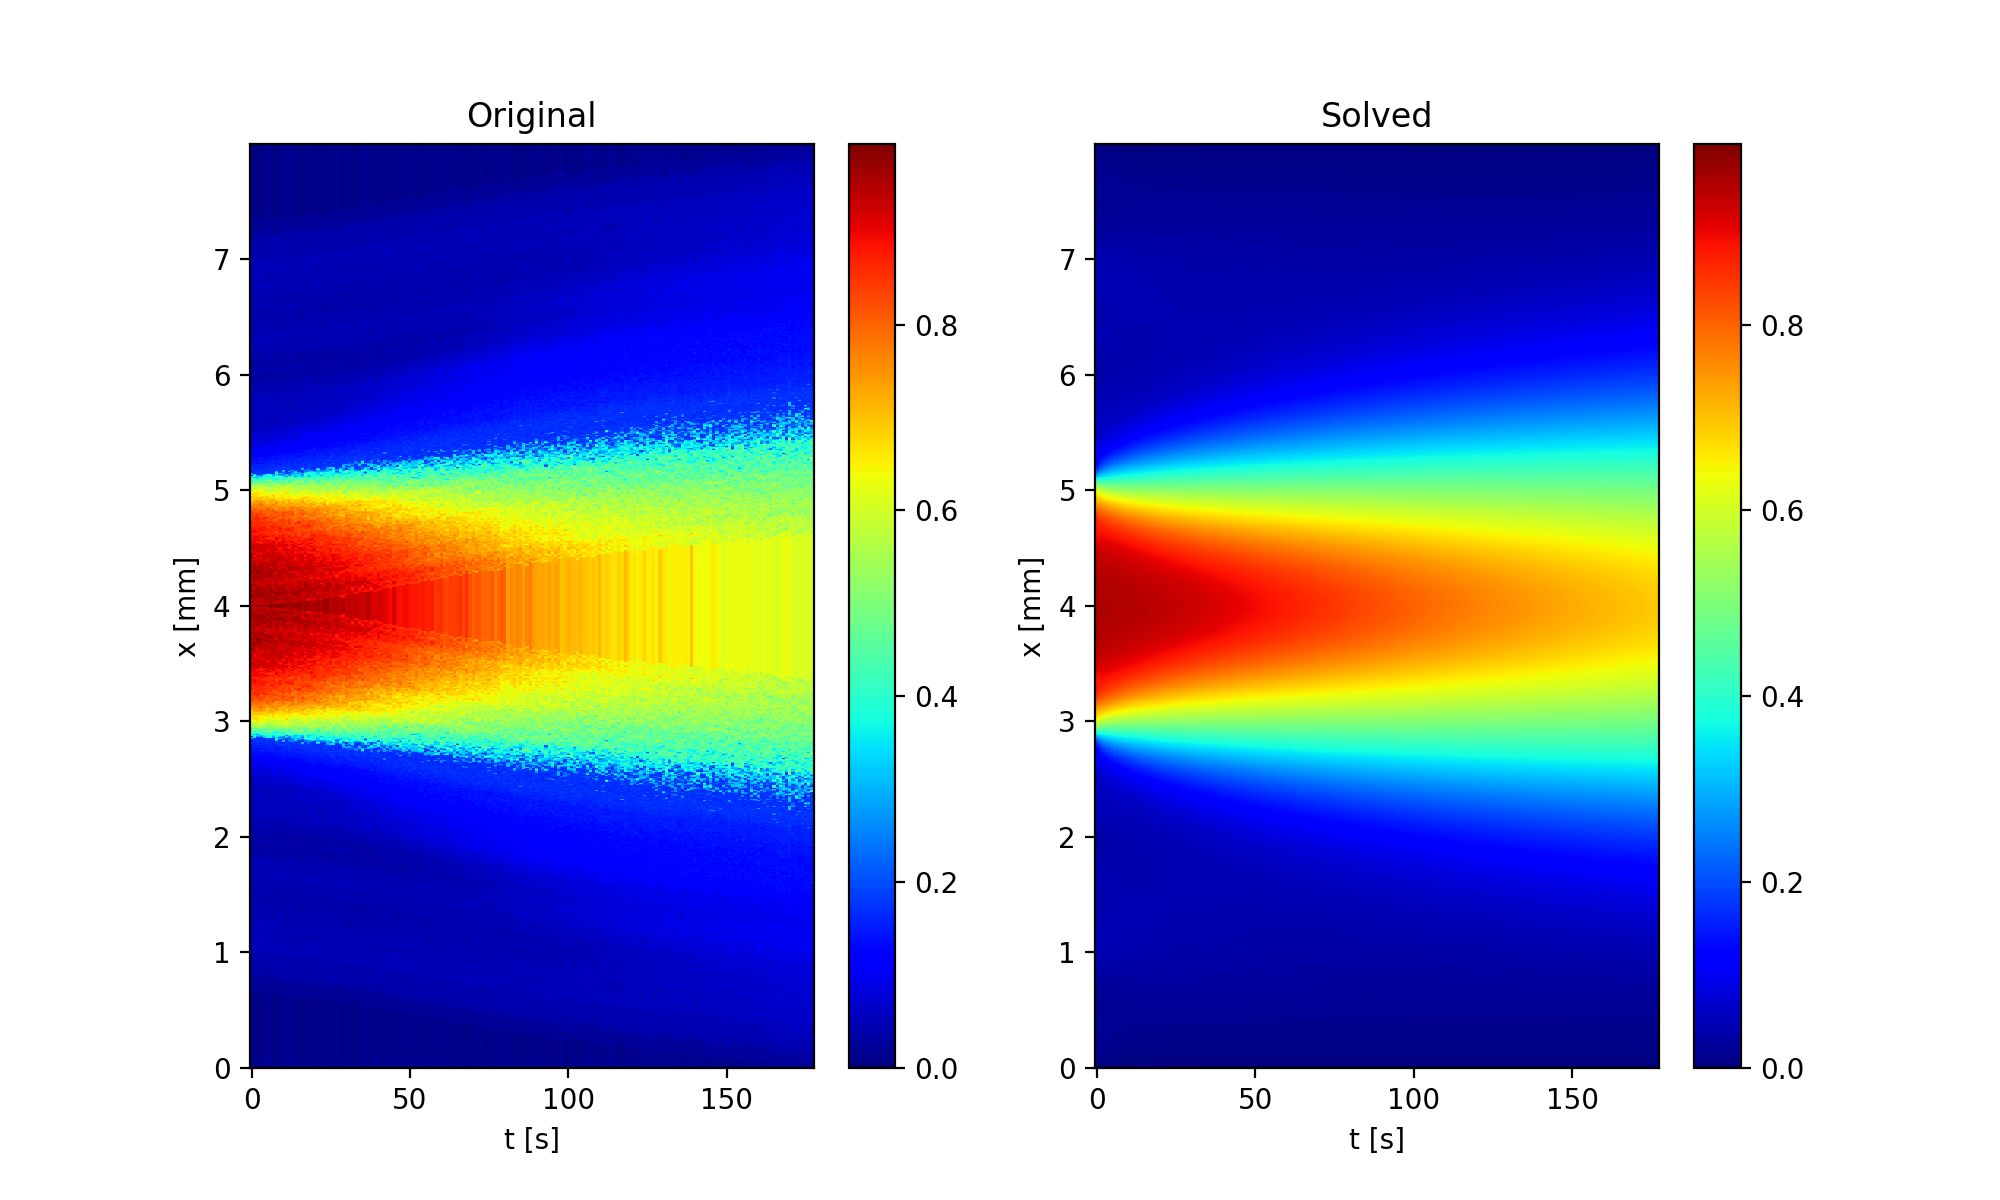

<IPython.core.display.Javascript object>


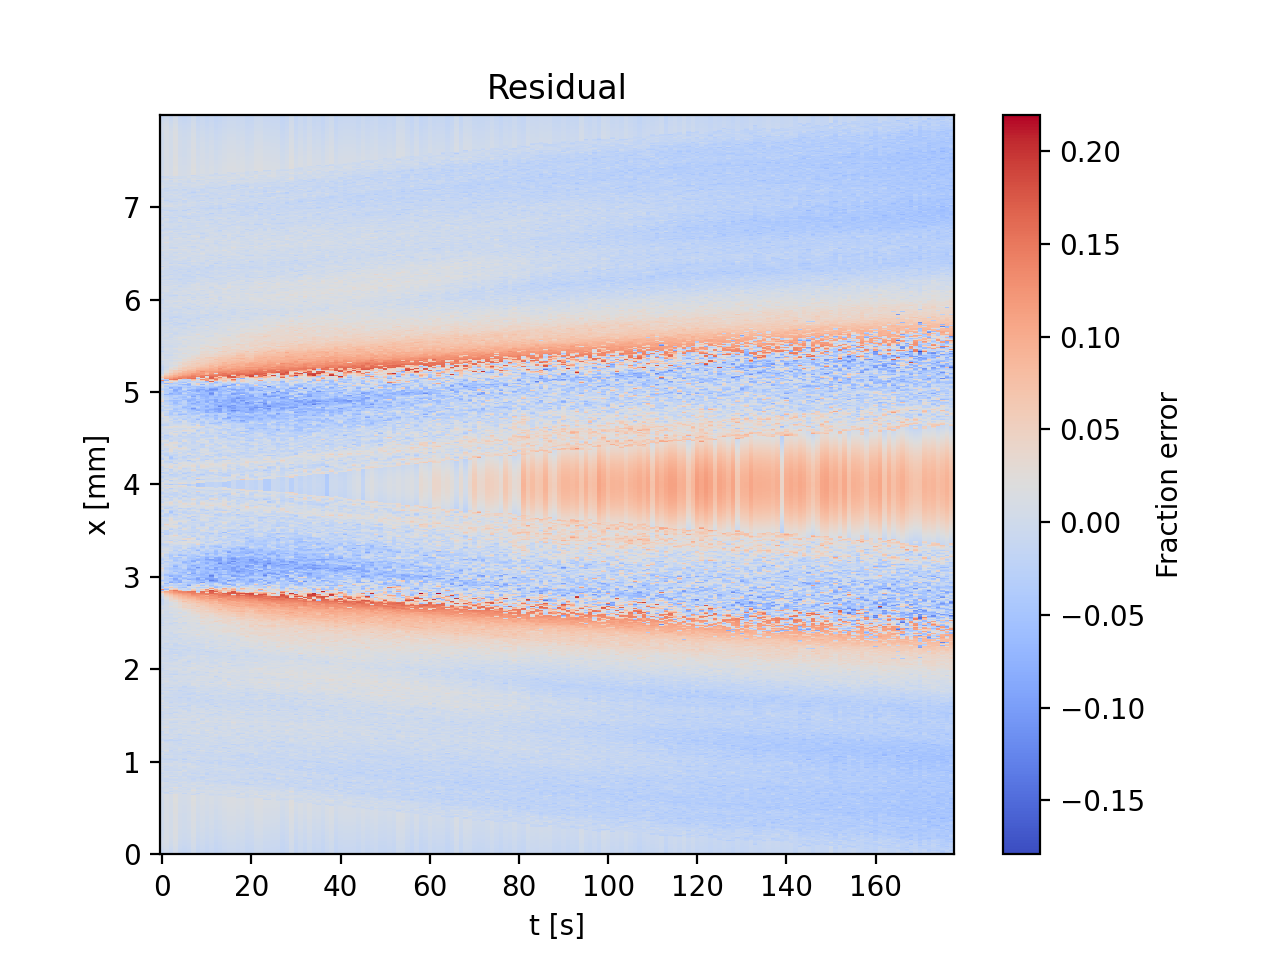

In [147]:
print("D = %s mm2/s, %e cm2/s" % (D,D/100.) ) # convert mm2 to cm2

# Generate series solution for entire domain.
fitted_solution=np.zeros_like(I)
for i in range(len(t)):
    fitted_solution[:,i] = generalSolution(x,t[i],D,I[:,0],nmax)

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
plt.title("Original")
ph = ax.pcolormesh(tt,xx,I,shading='nearest',cmap=plt.cm.jet);
plt.colorbar(ph)
plt.xlabel("t [s]")
plt.ylabel("x [mm]");

ax=fig.add_subplot(122)
plt.title("Solved")
ph = ax.pcolormesh(tt,xx,fitted_solution,shading='nearest',vmin=I.min(),vmax=I.max(),cmap=plt.cm.jet);
plt.colorbar(ph)#,label="$I(x,t)$")
plt.xlabel("t [s]")
plt.ylabel("x [mm]");

fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("Residual")
ph = ax.pcolormesh(tt,xx,(fitted_solution-I)/np.nanmax(I),shading='nearest',cmap=plt.cm.coolwarm);
plt.colorbar(ph,label="Fraction error")
plt.xlabel("t [s]")
plt.ylabel("x [mm]");